## Setup


In [1]:
!pip install transformers datasets accelerate xformers wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.6/211.6 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style("whitegrid", {"axes.grid": False})

## Data Preprocessing


In [3]:
label_names = ["FAKE", "REAL"]
label2id = {label_names[i]: i for i in range(len(label_names))}
id2label = {i: label_names[i] for i in range(len(label_names))}

In [4]:
train = pd.read_csv("./data/train_data.csv", encoding="utf-8")[["statement"]] # "label_numeric"
# train = train.rename(columns={"label_numeric": "labels"})
train.head()

,statement
0,"During the Reagan era, while productivity incr..."
1,"""It costs more money to put a person on death ..."
2,Says that Minnesota Democratic congressional c...
3,"""This is the most generous country in the worl..."
4,"""Loopholes in current law prevent ‘Unaccompani..."


In [5]:
train["labels"] = np.load("./data/snorkel_labels_train_expanded.npy")

In [6]:
train = train[train.labels != -1].reset_index(drop=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  9540 non-null   object
 1   labels     9540 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 111.9+ KB


In [7]:
valid = pd.read_csv("./data/valid_data.csv", encoding="utf-8")[["statement"]] # "label_numeric"
# valid = valid.rename(columns={"label_numeric": "labels"})
valid.head()

,statement
0,"""Saturday's shootings reflect a disturbing tre..."
1,"""States that have implemented waiting periods ..."
2,"Says ""these ‘Jersey Shore’ folks, they’re from..."
3,"""Six years after unionization, 20,000 fewer ch..."
4,Says immigrants wanted by ICE have victimized ...


In [8]:
valid["labels"] = np.load("./data/snorkel_labels_valid_expanded.npy")

In [9]:
valid = valid[valid.labels != -1].reset_index(drop=True)
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357 entries, 0 to 2356
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  2357 non-null   object
 1   labels     2357 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 27.7+ KB


In [10]:
fnid_pth = "./data/FNID/fake news detection(FakeNewsNet)/fnn_test.csv"
test = pd.read_csv(fnid_pth, encoding="utf-8")[["statement", "label_fnn"]]
test["labels"] = test.label_fnn.apply(lambda x: label2id[x.upper()])
test = test.drop(columns=["label_fnn"])
test.head()

,statement,labels
0,"""President Obama himself attempted to filibust...",1
1,"In Hawaii, ""they don't have a history of throw...",1
2,"""Our national debt ... is on track to exceed t...",1
3,"""Health insurance companies' costs are only 4 ...",1
4,"""We can prevent terror suspects from boarding ...",1


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  1054 non-null   object
 1   labels     1054 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 16.6+ KB


## Tokenization


In [12]:
model_ckpt = "bert-base-uncased"
model_name = "bert-weakly-finetuned-snorkel-expanded"
model_pth = f"./models/{model_name}"
project_name = "snorkel-liger-testing"

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [14]:
# transformimg from pandas to hugging face datasets

from datasets import Dataset, DatasetDict

train = Dataset.from_pandas(train, split="train")
valid = Dataset.from_pandas(valid, split="validation")
test = Dataset.from_pandas(test, split="test")

ds = DatasetDict({"train": train, "valid": valid, "test": test})

ds

DatasetDict({
    train: Dataset({
        features: ['statement', 'labels'],
        num_rows: 9540
    })
    valid: Dataset({
        features: ['statement', 'labels'],
        num_rows: 2357
    })
    test: Dataset({
        features: ['statement', 'labels'],
        num_rows: 1054
    })
})

In [15]:
def tokenize_ds(field):
    return tokenizer(field["statement"], truncation=True)

In [16]:
ds_encoded = ds.map(tokenize_ds, batched=True, remove_columns=["statement"])

Map:   0%|          | 0/9540 [00:00<?, ? examples/s]

Map:   0%|          | 0/2357 [00:00<?, ? examples/s]

Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

In [17]:
ds_encoded

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9540
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2357
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1054
    })
})

## Modeling


### Setup


In [18]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [19]:
def compute_scores(preds):
    logits, labels = preds
    pred = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average="binary")
    prec = precision_score(labels, pred, average="binary")
    rec = recall_score(labels, pred, average="binary")
    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

In [20]:
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding

In [21]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [22]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=len(label_names), id2label=id2label, label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training


In [23]:
import torch
import torch.nn.functional as F

if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    if torch.cuda.device_count() > 1:
        device = torch.device("cuda:0")
    else:
        device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [24]:
class NormalizedCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(NormalizedCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.log_softmax(pred, dim=1)
        label_one_hot = (
            torch.nn.functional.one_hot(labels, self.num_classes)
            .float()
            .to(self.device)
        )
        nce = -1 * torch.sum(label_one_hot * pred, dim=1) / (-pred.sum(dim=1))
        return self.scale * nce.mean()


class MeanAbsoluteError(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(MeanAbsoluteError, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale
        return

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        label_one_hot = (
            torch.nn.functional.one_hot(labels, self.num_classes)
            .float()
            .to(self.device)
        )
        mae = 1.0 - torch.sum(label_one_hot * pred, dim=1)
        return self.scale * mae.mean()


class NCEandMAE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes):
        super(NCEandMAE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.mae = MeanAbsoluteError(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.mae(pred, labels)

In [25]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")  # [batch_size, num_labels]
        outputs = model(**inputs)
        logits = outputs.get("logits")  # [batch_size, num_labels]
        loss_fct = NCEandMAE(alpha=1.0, beta=1.0, num_classes=len(label_names))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [26]:
import json
import wandb

with open("./data/access_tokens.json") as f:
    login_key = json.load(f)["wandb"]["login"]

wandb.login(key=login_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [27]:
wandb.init(project=project_name, name=model_name)

wandb: Currently logged in as: e_hossam96. Use `wandb login --relogin` to force relogin


In [28]:
epochs = 3
learning_rate = 2e-5
weight_decay = 1e-4
warmup_ratio = 0.1

In [29]:
training_args = TrainingArguments(
    output_dir=model_pth,
    overwrite_output_dir=True,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=epochs,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    warmup_ratio=warmup_ratio,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    log_level="error",
    load_best_model_at_end=True,
)

In [30]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_encoded["train"],
    eval_dataset=ds_encoded["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_scores,
)

In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.706559,0.653797,0.650373,0.760921,0.701318
2,No log,0.720014,0.641493,0.608150,0.924543,0.733691
3,No log,0.678575,0.664828,0.639833,0.852264,0.730926


TrainOutput(global_step=450, training_loss=0.6979140218098958, metrics={'train_runtime': 319.6785, 'train_samples_per_second': 89.527, 'train_steps_per_second': 1.408, 'total_flos': 905439141478080.0, 'train_loss': 0.6979140218098958, 'epoch': 3.0})

In [32]:
trainer.evaluate(ds_encoded["test"], metric_key_prefix="test")

{'test_loss': 0.2803734540939331,
 'test_Accuracy': 0.864326375711575,
 'test_Precision': 0.9659735349716446,
 'test_Recall': 0.8034591194968553,
 'test_F1': 0.8772532188841201,
 'test_runtime': 3.1437,
 'test_samples_per_second': 335.275,
 'test_steps_per_second': 5.408,
 'epoch': 3.0}

In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [34]:
outs = trainer.predict(ds_encoded["test"])
preds = np.argmax(outs[0], axis=-1)
labels = outs[1]

print(classification_report(labels, preds, target_names=label_names))

              precision    recall  f1-score   support

        FAKE       0.76      0.96      0.85       418
        REAL       0.97      0.80      0.88       636

    accuracy                           0.86      1054
   macro avg       0.86      0.88      0.86      1054
weighted avg       0.89      0.86      0.87      1054



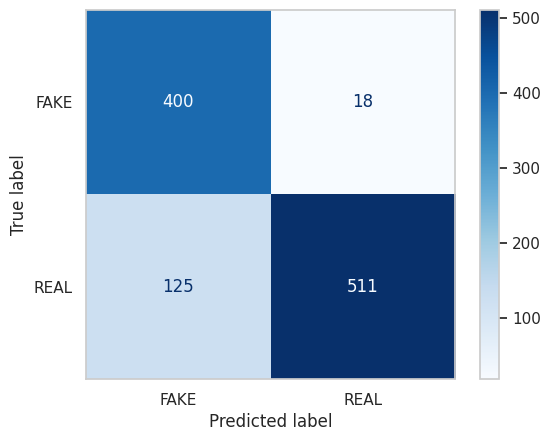

In [35]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(cmap="Blues")
plt.show()

In [36]:
wandb.finish()

eval/Accuracy,▅▁█
eval/F1,▁█▇
eval/Precision,█▁▆
eval/Recall,▁█▅
eval/loss,▆█▁
eval/runtime,▁▇█
eval/samples_per_second,█▂▁
eval/steps_per_second,█▂▁
test/Accuracy,▁
test/F1,▁
test/Precision,▁
